### 请尝试分析一次实验中（Session A）小鼠注视 Drift gratings 时的神经细胞活动，根据VISp、VISal、VISl 三个脑区的神经细胞活动分别解码光栅运动方向，比较三个脑区解码性能的差异。

In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from load_data import read_Decoding_csv, load_neural_npz
from oasis.functions import deconvolve

In [6]:
class DriftingGratingDirectionDecoder:
    def __init__(self):
        self.results = {}
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
    def extract_drifting_grating_data(self, ts, dff, stimulus_df):
        """提取漂移光栅刺激期间的神经活动数据"""
        # 过滤掉空白刺激
        stimulus_df_filtered = stimulus_df[stimulus_df['blank_sweep'] != 1].copy()
        
        # 获取方向信息
        orientations = stimulus_df_filtered['orientation'].values
        temporal_frequencies = stimulus_df_filtered['temporal_frequency'].values
        
        # 提取神经活动特征
        neural_features = []
        direction_labels = []
        temporal_freq_labels = []
        
        print(f"  处理 {len(stimulus_df_filtered)} 个漂移光栅刺激...")
        
        for _, row in stimulus_df_filtered.iterrows():
            start_time = int(row['start'])
            end_time = int(row['end'])
            orientation = row['orientation']
            temp_freq = row['temporal_frequency']
            
            # 检查时间索引有效性
            if start_time >= 0 and end_time < dff.shape[1] and start_time < end_time:
                # 提取该时间段的神经活动
                segment_data = dff[:, start_time:end_time]
                
                # 计算多种特征
                mean_activity = np.mean(segment_data, axis=1)
                # max_activity = np.max(segment_data, axis=1) 
                # std_activity = np.std(segment_data, axis=1)
                
                # # 使用去卷积信号计算放电率
                # spike_data = np.array([deconvolve(segment_data[i,:], penalty=1)[1] 
                #                      for i in range(segment_data.shape[0])])
                # spike_rate = np.sum(spike_data, axis=1) / (end_time - start_time)
                
                # # 组合特征 (可以选择不同的特征组合)
                # features = np.concatenate([mean_activity, spike_rate])
                features = mean_activity  # 简单版本，只使用平均活动
                
                neural_features.append(features)
                direction_labels.append(orientation)
                temporal_freq_labels.append(temp_freq)
        
        return (np.array(neural_features), 
                np.array(direction_labels), 
                np.array(temporal_freq_labels))
    
    def train_decoder(self, X, y, classifier_type='logistic'):
        """训练方向解码器"""
        # 数据预处理
        X_scaled = self.scaler.fit_transform(X)
        
        # 编码标签
        y_encoded = self.label_encoder.fit_transform(y)
        
        # 选择分类器
        if classifier_type == 'logistic':
            classifier = LogisticRegression(max_iter=1000, random_state=42)
        elif classifier_type == 'svm':
            classifier = SVC(kernel='rbf', random_state=42)
        elif classifier_type == 'rf':
            classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        
        # 交叉验证
        cv_scores = cross_val_score(classifier, X_scaled, y_encoded, 
                                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                   scoring='accuracy')
        
        # 训练测试分割
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
        
        # 训练模型
        classifier.fit(X_train, y_train)
        
        # 预测
        y_pred = classifier.predict(X_test)
        y_train_pred = classifier.predict(X_train)
        
        # 计算性能指标
        test_accuracy = accuracy_score(y_test, y_pred)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        
        # 获取原始方向标签
        original_directions = self.label_encoder.inverse_transform(np.unique(y_encoded))
        
        return {
            'classifier': classifier,
            'test_accuracy': test_accuracy,
            'train_accuracy': train_accuracy,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'cv_scores': cv_scores,
            'y_test': y_test,
            'y_pred': y_pred,
            'y_train': y_train,
            'y_train_pred': y_train_pred,
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred, 
                                                         target_names=[f'{d}°' for d in original_directions],
                                                         output_dict=True),
            'directions': original_directions,
            'n_samples': len(X),
            'n_features': X.shape[1],
            'classifier_type': classifier_type
        }
    
    def analyze_brain_region(self, region_name, data_path):
        """分析单个脑区的方向解码性能"""
        print(f"\n分析脑区: {region_name}")
        print("-" * 40)
        
        try:
            # 读取数据
            tgt_dict, tgt_folder = read_Decoding_csv(data_path=data_path, 
                                                   region_type=region_name, 
                                                   session_letter='A')
            
            # 加载神经数据
            neural_file_path = os.path.join(data_path, tgt_folder)
            for file_name in os.listdir(neural_file_path):
                if file_name.endswith('.npz'):
                    ts, dff, all_roi_masks, cids, metadata = load_neural_npz(
                        os.path.join(neural_file_path, file_name))
                    break
            
            # 获取漂移光栅数据
            if 'stimulus_metadata_drifting_gratings.csv' not in tgt_dict:
                print(f"  错误: {region_name} 没有漂移光栅数据")
                return None
            
            stimulus_df = tgt_dict['stimulus_metadata_drifting_gratings.csv']
            
            # 提取特征
            print(f"  提取神经活动特征...")
            X, directions, temp_freqs = self.extract_drifting_grating_data(ts, dff, stimulus_df)
            
            if len(X) == 0:
                print(f"  错误: {region_name} 没有有效的数据")
                return None
            
            # 检查方向类别
            unique_directions = np.unique(directions)
            print(f"  发现 {len(unique_directions)} 个方向: {unique_directions}")
            print(f"  样本数: {len(X)}, 特征数: {X.shape[1]}, 神经元数: {dff.shape[0]}")
            
            if len(unique_directions) < 2:
                print(f"  错误: {region_name} 方向类别不足")
                return None
            
            # 训练不同类型的分类器
            classifiers = ['logistic', 'svm', 'rf']
            region_results = {}
            
            for clf_type in classifiers:
                print(f"  训练 {clf_type} 分类器...")
                result = self.train_decoder(X, directions, clf_type)
                region_results[clf_type] = result
                print(f"    测试准确率: {result['test_accuracy']:.4f}")
                print(f"    交叉验证: {result['cv_mean']:.4f} ± {result['cv_std']:.4f}")
            
            # 保存结果
            self.results[region_name] = {
                'classifiers': region_results,
                'directions': unique_directions,
                'n_samples': len(X),
                'n_neurons': dff.shape[0],
                'n_features': X.shape[1],
                'temporal_frequencies': np.unique(temp_freqs),
                'metadata': metadata
            }
            
            return region_results
            
        except Exception as e:
            print(f"  错误: {region_name} 分析失败: {e}")
            return None
    
    def compare_regions(self, data_path='../data'):
        """比较三个脑区的解码性能"""
        brain_regions = ['VISp', 'VISal', 'VISl']
        
        print("开始分析三个脑区的漂移光栅方向解码...")
        print("=" * 60)
        
        for region in brain_regions:
            self.analyze_brain_region(region, data_path)
        
        # 生成比较报告
        self.generate_comparison_report()
        self.plot_comparison_results()
    
    def generate_comparison_report(self):
        """生成详细的比较报告"""
        print("\n" + "=" * 60)
        print("漂移光栅方向解码性能比较报告")
        print("=" * 60)
        
        # 创建汇总表
        summary_data = []
        
        for region_name, region_data in self.results.items():
            for clf_type, clf_results in region_data['classifiers'].items():
                summary_data.append({
                    'Brain_Region': region_name,
                    'Classifier': clf_type,
                    'Test_Accuracy': clf_results['test_accuracy'],
                    'CV_Mean': clf_results['cv_mean'],
                    'CV_Std': clf_results['cv_std'],
                    'N_Samples': region_data['n_samples'],
                    'N_Neurons': region_data['n_neurons'],
                    'N_Directions': len(region_data['directions'])
                })
        
        df_summary = pd.DataFrame(summary_data)
        print("\n详细结果:")
        print(df_summary.to_string(index=False))
        
        # 按脑区统计最佳性能
        print(f"\n按脑区统计最佳性能:")
        best_performance = df_summary.loc[df_summary.groupby('Brain_Region')['Test_Accuracy'].idxmax()]
        print(best_performance[['Brain_Region', 'Classifier', 'Test_Accuracy', 'CV_Mean']].to_string(index=False))
        
        # 统计分析
        print(f"\n总体统计:")
        print(f"平均测试准确率: {df_summary['Test_Accuracy'].mean():.4f} ± {df_summary['Test_Accuracy'].std():.4f}")
        print(f"最高准确率: {df_summary['Test_Accuracy'].max():.4f}")
        print(f"最低准确率: {df_summary['Test_Accuracy'].min():.4f}")
        
        # 按脑区分组
        print(f"\n按脑区分组平均性能:")
        region_stats = df_summary.groupby('Brain_Region')['Test_Accuracy'].agg(['mean', 'std', 'max'])
        print(region_stats)
        
        return df_summary
    
    def plot_comparison_results(self):
        """可视化比较结果"""
        if not self.results:
            print("没有结果可以可视化")
            return
        
        # 准备数据
        regions = list(self.results.keys())
        classifiers = ['logistic', 'svm', 'rf']
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. 测试准确率比较
        ax1 = axes[0, 0]
        accuracy_data = []
        region_labels = []
        classifier_labels = []
        
        for region in regions:
            for clf in classifiers:
                if clf in self.results[region]['classifiers']:
                    accuracy_data.append(self.results[region]['classifiers'][clf]['test_accuracy'])
                    region_labels.append(region)
                    classifier_labels.append(clf)
        
        df_plot = pd.DataFrame({
            'Region': region_labels,
            'Classifier': classifier_labels,
            'Accuracy': accuracy_data
        })
        
        sns.barplot(data=df_plot, x='Region', y='Accuracy', hue='Classifier', ax=ax1)
        ax1.set_title('Test Accuracy by Brain Region and Classifier')
        ax1.set_ylabel('Test Accuracy')
        ax1.legend(title='Classifier')
        
        # 2. 交叉验证性能
        ax2 = axes[0, 1]
        cv_means = []
        cv_stds = []
        
        for region in regions:
            for clf in classifiers:
                if clf in self.results[region]['classifiers']:
                    cv_means.append(self.results[region]['classifiers'][clf]['cv_mean'])
                    cv_stds.append(self.results[region]['classifiers'][clf]['cv_std'])
        
        df_cv = pd.DataFrame({
            'Region': region_labels,
            'Classifier': classifier_labels,
            'CV_Mean': cv_means,
            'CV_Std': cv_stds
        })
        
        sns.barplot(data=df_cv, x='Region', y='CV_Mean', hue='Classifier', ax=ax2)
        ax2.set_title('Cross-Validation Performance')
        ax2.set_ylabel('CV Mean Accuracy')
        ax2.legend(title='Classifier')
        
        # 3. 神经元数量比较
        ax3 = axes[0, 2]
        neuron_counts = [self.results[region]['n_neurons'] for region in regions]
        sample_counts = [self.results[region]['n_samples'] for region in regions]
        
        ax3.bar(regions, neuron_counts, alpha=0.7, label='Neurons')
        ax3_twin = ax3.twinx()
        ax3_twin.bar(regions, sample_counts, alpha=0.5, color='orange', label='Samples')
        ax3.set_title('Number of Neurons and Samples')
        ax3.set_ylabel('Number of Neurons')
        ax3_twin.set_ylabel('Number of Samples')
        ax3.legend(loc='upper left')
        ax3_twin.legend(loc='upper right')
        
        # 4. 混淆矩阵 (选择最佳分类器)
        for i, region in enumerate(regions):
            ax = axes[1, i]
            
            # 找到该脑区最佳分类器
            best_clf = None
            best_acc = 0
            
            for clf in classifiers:
                if clf in self.results[region]['classifiers']:
                    acc = self.results[region]['classifiers'][clf]['test_accuracy']
                    if acc > best_acc:
                        best_acc = acc
                        best_clf = clf
            
            if best_clf:
                cm = self.results[region]['classifiers'][best_clf]['confusion_matrix']
                directions = self.results[region]['directions']
                
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                           xticklabels=[f'{d}°' for d in directions],
                           yticklabels=[f'{d}°' for d in directions])
                ax.set_title(f'{region} - {best_clf.upper()}\nAccuracy: {best_acc:.3f}')
                ax.set_xlabel('Predicted Direction')
                ax.set_ylabel('True Direction')
        
        plt.tight_layout()
        plt.show()

开始漂移光栅方向解码分析...
开始分析三个脑区的漂移光栅方向解码...

分析脑区: VISp
----------------------------------------
we have keys in data_dict, including:
stimulus_metadata_drifting_gratings.csv
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_movie_three.csv
stimulus_metadata_spontaneous.csv
check subtitles, should be ['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
['ts', 'dff', 'all_roi_masks', 'cids', 'metadata']
  提取神经活动特征...
  处理 598 个漂移光栅刺激...
  发现 8 个方向: [  0.  45.  90. 135. 180. 225. 270. 315.]
  样本数: 598, 特征数: 142, 神经元数: 142
  训练 logistic 分类器...
    测试准确率: 0.4500
    交叉验证: 0.4766 ± 0.0335
  训练 svm 分类器...
    测试准确率: 0.3889
    交叉验证: 0.4197 ± 0.0133
  训练 rf 分类器...
    测试准确率: 0.4778
    交叉验证: 0.5251 ± 0.0514

分析脑区: VISal
----------------------------------------
we have keys in data_dict, including:
stimulus_metadata_drifting_gratings.csv
stimulus_metadata_natural_movie_one.csv
stimulus_metadata_natural_movie_three.csv
stimulus_metadata_spontaneous.csv
stimulus_metadata_total.csv
check s

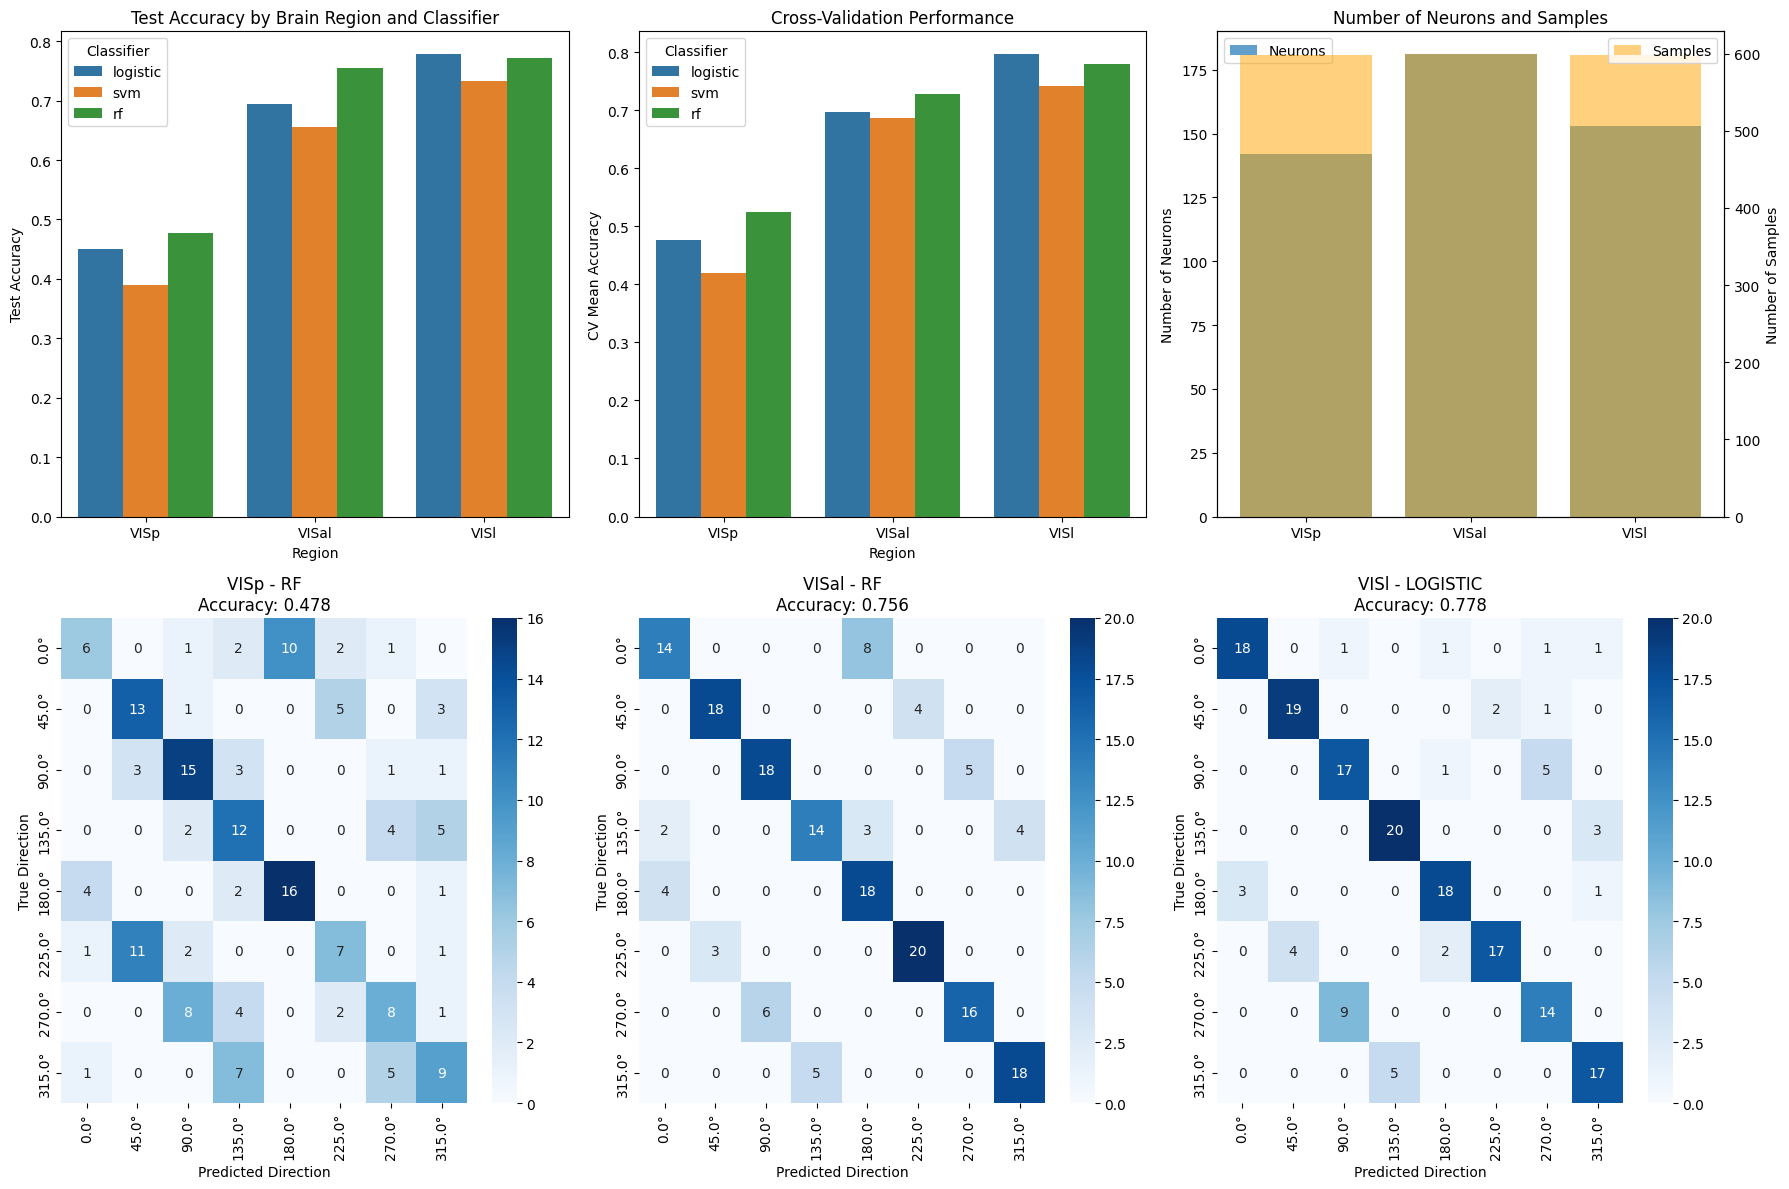


分析完成！


In [7]:
# 执行分析
print("开始漂移光栅方向解码分析...")

# 创建解码器
decoder = DriftingGratingDirectionDecoder()

# 比较三个脑区
decoder.compare_regions(data_path='../data')

print("\n分析完成！")